<a href="https://colab.research.google.com/github/vipulSharma18/Automatic-Emotion-Recognition-on-DEAP-Dataset/blob/main/models/2_level_Ensemble_of_Light_Pyramidal_1D_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
inp_choice = input("Enter b for Binary, m for Multi-Class Classification: ")

Enter b for Binary, m for Multi-Class Classification: b


# Add Google Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Importing Relevant Libraries

In [3]:
import pandas as pd
import tensorflow as tf
import numpy as np
import tensorflow.keras as keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Softmax
from sklearn.metrics import classification_report
from keras.utils.vis_utils import plot_model
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import pickle
from scipy.stats import zscore
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import gc
from keras.callbacks import ReduceLROnPlateau
from collections import Counter
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [4]:
RANDOM_SEED = 42
tf.random.set_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

# GPU Check

In [5]:
print(tf.version.VERSION)
print(tf.config.experimental.list_physical_devices('GPU'))
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

2.4.1
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Num GPUs Available:  1


# Data Augmentation

## Load Data from .dat files into a np array of 1280 x 32 x 8064 size

In [6]:
#Uncomment Below Code if need to Reload all data from scratch
"""
all_sub_data = []
subjects_list = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32']
for sub in subjects_list:
    path = "/content/drive/MyDrive/major project/data_preprocessed_python/s"+sub+".dat"
    x = pickle.load(open(path, 'rb'), encoding = 'latin1')
    sub_data = x['data']
    sub_eeg = sub_data[:, :32, :]  #indexing EEG signals from physiological data
    all_sub_data.extend(sub_eeg)
    gc.collect()
gc.collect()
all_sub_data = np.array(all_sub_data)
"""

'\nall_sub_data = []\nsubjects_list = [\'01\', \'02\', \'03\', \'04\', \'05\', \'06\', \'07\', \'08\', \'09\', \'10\', \'11\', \'12\', \'13\', \'14\', \'15\', \'16\', \'17\', \'18\', \'19\', \'20\', \'21\', \'22\', \'23\', \'24\', \'25\', \'26\', \'27\', \'28\', \'29\', \'30\', \'31\', \'32\']\nfor sub in subjects_list:\n    path = "/content/drive/MyDrive/major project/data_preprocessed_python/s"+sub+".dat"\n    x = pickle.load(open(path, \'rb\'), encoding = \'latin1\')\n    sub_data = x[\'data\']\n    sub_eeg = sub_data[:, :32, :]  #indexing EEG signals from physiological data\n    all_sub_data.extend(sub_eeg)\n    gc.collect()\ngc.collect()\nall_sub_data = np.array(all_sub_data)\n'

In [7]:
all_sub_data = np.load("/content/drive/MyDrive/major project/all_sub_data.npy")
print(all_sub_data.shape)

(1280, 32, 8064)


## Z-score normalization of each EEG signal, resultant np.array is all_sub_data

In [8]:
for sub in range(all_sub_data.shape[0]):
  all_sub_data[sub] = zscore(all_sub_data[sub], axis = 1)  #zscore normalize each channel
gc.collect()

60

## Label Loading into np array of 1280 x 1 named, sub_labels

In [9]:
if(inp_choice == 'm'):
  labels = pd.read_excel("/content/drive/MyDrive/major project/metadata/Labels.xls")
  #for multiclass classification 
  sub_labels = labels["Valence-Arousal Model Quadrant"].astype('int')
  gc.collect()
  sub_labels


In [10]:
if(inp_choice == 'b'):
  labels = pd.read_excel("/content/drive/MyDrive/major project/metadata/Labels.xls")
  #for binary classification of valence scale
  sub_labels = labels["Valence Label (1=H, 0=L)"].astype('int')
  gc.collect()
  sub_labels


Distribution of Multi-Class Labels

In [11]:
if(inp_choice == 'm'):
  #SKIP FOR BINARY CLASSIFICATION
  # Add frequency bar plot here for dataset label distribution
  c = Counter(sub_labels)
  print(c)
  plt.figure()
  plt.bar([0,1,2,3], [c[0], c[1], c[2], c[3]])
  plt.show()

Distribution of Binary Class Labels

Counter({1: 724, 0: 556})


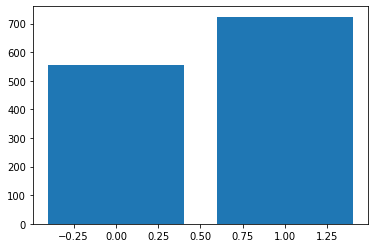

In [12]:
if(inp_choice == 'b'):
  # Add frequency bar plot here for dataset label distribution
  c = Counter(sub_labels)
  print(c)
  plt.figure()
  plt.bar([0,1], [c[0], c[1]])
  plt.show()

## Label Binarization of multi-class labels  
> sub_labels: (1280,4)

In [13]:
if(inp_choice == 'm'):
  multi_class_weights = compute_class_weights("balanced", classes = [0,1,2,3], y=sub_labels)
  print(multi_class_weights)
  d_multi_class_weights = dict(enumerate(multi_class_weights))
  print(d_multi_class_weights)

In [14]:
if(inp_choice == 'm'):
  lb = preprocessing.LabelBinarizer()
  sub_labels = lb.fit_transform(sub_labels)
  print(lb.classes_)
  print(sub_labels.shape)
  print(sub_labels)

In [15]:
gc.collect()

2686

In [16]:
if(inp_choice == 'm'):
  np.unique(sub_labels, axis = 0)

## Label Binarization of 2/Binary labels  
> sub_labels: (1280,2)

In [17]:
sub_labels.shape

(1280,)

In [18]:
if(inp_choice == 'b'):
  bin_class_weights = compute_class_weight("balanced", classes = [0,1], y=sub_labels)
  print(bin_class_weights)
  d_bin_class_weights = dict(enumerate(bin_class_weights))
  print(d_bin_class_weights)

[1.15107914 0.8839779 ]
{0: 1.1510791366906474, 1: 0.8839779005524862}


In [19]:
def encode(x):
  if(x==1):
    return [0,1]
  elif(x==0):
    return [1,0]
  else:
    print("invalid value")
    return None

In [20]:
if(inp_choice == 'b'):
  sub_labels_bin = np.array(list(map(encode, sub_labels)))
  print(sub_labels_bin.shape)
  print(sub_labels_bin[:6])

(1280, 2)
[[0 1]
 [0 1]
 [0 1]
 [1 0]
 [0 1]
 [0 1]]


In [21]:
if(inp_choice == 'b'):
  sub_labels_bin[0]

In [22]:
if(inp_choice == 'b'):
  sub_labels = sub_labels_bin
  gc.collect()
  print(sub_labels.shape)

(1280, 2)


In [23]:
def inv_bin(x):
  if(x == [0,1]):
     return 1
  elif(x==[1,0]):
    return 0


## Generating Train Test Splits  
> X_train, y_train: (1152,32,8064), (1152,4)  
> X_test, y_test: (128,32,8064), (128,4)  

In [24]:
X_train, X_test, y_train, y_test = train_test_split(all_sub_data, sub_labels, test_size = 0.1, random_state = 42,shuffle = True, stratify = sub_labels)


In [25]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((1152, 32, 8064), (1152, 2), (128, 32, 8064), (128, 2))

In [26]:
try:
  del all_sub_data
  del sub_labels
  del labels
  del x
  del sub_data
  del sub_eeg
  del subjects_list
except:
  pass
gc.collect()

200

## Repetition of Labels for Windowing of training data  

> y_train_12, y_train_6, y_train_4 of shapes(?,4): 13824, 6912 and 4608 respectively 


In [27]:
y_train = np.array(y_train)
print(y_train.shape, type(y_train))

(1152, 2) <class 'numpy.ndarray'>


In [28]:
#12,6 and 4 subsignals are generated from 8064 length EEG signal, labels repeated accordingly
y_train_12 = np.repeat(y_train, 12, axis = 0)
#y_train_6 = np.repeat(y_train, 6, axis = 0)
#y_train_4 = np.repeat(y_train, 4, axis = 0)
del(y_train)
gc.collect()
#print(y_train_12.shape, y_train_6.shape, y_train_4.shape)
print(y_train_12.shape)

(13824, 2)


In [29]:
try:
  del y_train_6, y_train_4
except:
  pass
gc.collect()

50

In [30]:
try:
  del c_train, c_test, c_train_12, c
except:
  pass
gc.collect()

50

## Loading Training data with different window sizes

In [31]:
channel_wise = np.transpose(X_train, (1,0,2))
del(X_train)
gc.collect()

50

In [32]:

def process_input(instances, sub_signals):
  #instances must be channel wise of shape (32, -1, 8064)
  samples = int(8064/sub_signals)
  transformed = []
  for i in range(instances.shape[0]):
    transformed.append(np.reshape(instances[i], (-1,samples,1)))
  transformed = np.array(transformed)
  print(transformed.shape, 'is the shape obtained.')
  gc.collect()
  return transformed

### 12 sub signals of length 672 each, total 13824 instances

In [33]:
#X_train_12 = np.load("/content/drive/MyDrive/major project/data_augmentation/channel_wise_12.npy")
#print(X_train_12.shape, 'Shape of Training Data')
X_train_12 = process_input(channel_wise, 12)
gc.collect()

(32, 13824, 672, 1) is the shape obtained.


0

### 6 sub signals of length 1344 each, total 6912 instances

In [34]:
#X_train_6 = np.load("/content/drive/MyDrive/major project/data_augmentation/channel_wise_6.npy")
#print(X_train_6.shape, 'Shape of Training Data')
#gc.collect()

### 4 sub signals of length 2016 each, total 4608 instances

In [35]:
#X_train_4 = np.load("/content/drive/MyDrive/major project/data_augmentation/channel_wise_4.npy")
#print(X_train_4.shape, 'Shape of Training Data')
#gc.collect()

In [36]:
gc.collect()

150

Free Up ram

In [37]:
del channel_wise
gc.collect()

50

## Preprocessing for passing test data into CNN

In [38]:
def process_input_ensemble(instances, sub_signals):
  """
  This Function explicity adds a dimension for the sub_signals, hence is used for ensembel modeling to traverse that dimension.
  Otherwise also we can simply assume, since the dataset is ordered that the groups of len(sub_signals) are obtained from one EEG signal
  """
  #instances must be channel wise of shape (32, -1, 8064)
  gc.collect()
  samples = int(8064/sub_signals)
  transformed = []
  for i in range(instances.shape[0]):
    transformed.append(np.reshape(instances[i], (-1,sub_signals,samples,1)))
    gc.collect()
  transformed = np.array(transformed)
  print(transformed.shape, 'is the shape obtained.')
  gc.collect()
  #output shape will be (len(intances), 32, sub_signals, samples, 1)
  return transformed

For Channel Wise Evaluation and Not Ensemble Evaluation, below can be used.  
(* This can also be used for ensemble if we explicitly group len(sub_signals) samples together to represent 1 EEG signal, remember to do no shuffling in this case)

In [39]:
X_test_channels = np.transpose(X_test, (1,0,2))


12 sub_signals

In [40]:
x_test_12 = process_input(X_test_channels, 12)
y_test_12 = np.repeat(np.array(y_test), 12, axis = 0)
print(x_test_12.shape, y_test_12.shape)

(32, 1536, 672, 1) is the shape obtained.
(32, 1536, 672, 1) (1536, 2)


6 sub_signals

In [41]:
"""
x_test_6 = process_input(X_test_channels, 6)
y_test_6 = np.repeat(np.array(y_test), 6, axis = 0)
print(x_test_6.shape, y_test_6.shape)
"""

'\nx_test_6 = process_input(X_test_channels, 6)\ny_test_6 = np.repeat(np.array(y_test), 6, axis = 0)\nprint(x_test_6.shape, y_test_6.shape)\n'

4 sub_signals

In [42]:
"""
x_test_4 = process_input(X_test_channels, 4)
y_test_4 = np.repeat(np.array(y_test), 4, axis = 0)
print(x_test_4.shape, y_test_4.shape)
"""

'\nx_test_4 = process_input(X_test_channels, 4)\ny_test_4 = np.repeat(np.array(y_test), 4, axis = 0)\nprint(x_test_4.shape, y_test_4.shape)\n'

## Problem of Class imbalance:  
The model is biased towards a class due to class imbalance and is not fitting the data. The class {3} is majority class with around 35% samples in train, test and original dataset
due to stratified sampling. The model accuracy is also around 35% which clearly indicated majority voting is being done and no learning. Further we created a confusion matrix for training and validation sets which confirms this hypothesis.

Solutions:
1. Use class weighing in model.fit, weightI = total/Instances_I, inverse frequency or n_samples / (n_classes * np.bincount(y))
2. Undersampling: `from sklearn.utils import resample  
no_claim_downsampled = resample(no_claim,replace = False,n_samples = len(claim), random_state = RANDOM_SEED)`    
3. Oversampling:  `claim_upsampled = resample(claim, replace=True, n_samples=len(no_claim), random_state=RANDOM_SEED)`  
4. Synthetic Sample Generation with SMOTE:   
` from imblearn.over_sampling import SMOTE  
sm = SMOTE(random_state=RANDOM_SEED, ratio=1.0)  
X_train, y_train = sm.fit_sample(X_train, y_train)`  
5. Metrics: Precision is the percentage of predicted positives that were correctly classified.  
Recall is the percentage of actual positives that were correctly classified.  
AUC refers to the Area Under the Curve of a Receiver Operating Characteristic curve (ROC-AUC). This metric is equal to the probability that a classifier will rank a random positive sample higher than a random negative sample.  



# Models Fitting and Evaluation

## Helper Functions for plotting, confusion matrix etc.

In [43]:
def plot_evaluation_curves(history, EPOCHS, mtrc):
  acc = history.history[mtrc[0]]
  val_acc = history.history[mtrc[1]]

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs_range = range(EPOCHS)

  plt.figure(figsize=(10, 6))
  plt.subplot(1, 2, 1)
  plt.plot(epochs_range, acc, label='Training ' + mtrc[0])
  plt.plot(epochs_range, val_acc, label='Validation '+ mtrc[0])
  plt.legend(loc='lower right')
  plt.title('Training and Validation ' +  mtrc[0])

  plt.subplot(1, 2, 2)
  plt.plot(epochs_range, loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  plt.show()

In [44]:
def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    ---------
    cf:            confusion matrix to be passed in
    group_names:   List of strings that represent the labels row by row to be shown in each square.
    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'
    count:         If True, show the raw number in the confusion matrix. Default is True.
    normalize:     If True, show the proportions for each category. Default is True.
    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.
    xyticks:       If True, show x and y ticks. Default is True.
    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.
    sum_stats:     If True, display summary statistics below the figure. Default is True.
    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.
    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.
    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)

In [45]:
gc.collect()

50

### Functions for Classification report and Confusion Matrix generation
 

In [46]:
def show_test_metrics(x_test, y_test, model):
  print("Testing Set MEASURES: ")
  #Testing Data metrics
  pred_y = model.predict(x_test)
  c_pred = Counter(np.argmax(pred_y, axis = 1))
  print(c_pred, "Predicted Distribution of Testing Dataset")
  c_true = Counter(np.argmax(y_test, axis = 1))
  print(c_true, "Actual Distribution of Testing Dataset")
  print(model.evaluate(x_test, y_test), "Testing Measures of Model.")
  print("Classification Report of Model on Testing Data")
  print(classification_report(np.argmax(y_test, axis =1), np.argmax(model.predict(x_test), axis = 1) , digits = 4) )
  make_confusion_matrix(confusion_matrix(np.argmax(y_test, axis = 1), np.argmax(model.predict(x_test), axis = 1)))
  print("------------------------------------------------------------\n")

In [47]:
def show_metrics(x_train=None, x_val=None, y_train=None, y_val=None, model=None):
  print("TRAINING MEASURES: ")
  #Training Data metrics
  pred_y = model.predict(x_train)
  c_pred = Counter(np.argmax(pred_y, axis = 1))
  print(c_pred, "Predicted Distribution of Training Dataset")
  c_true = Counter(np.argmax(y_train, axis = 1))
  print(c_true, "Actual Distribution of Training Dataset")
  print(model.evaluate(x_train, y_train), "Training Measures of Model.")
  print("Classification Report of Model on Training Data")
  print(classification_report(np.argmax(y_train, axis =1), np.argmax(model.predict(x_train), axis = 1) , digits = 4) )
  make_confusion_matrix(confusion_matrix(np.argmax(y_train, axis = 1), np.argmax(model.predict(x_train), axis = 1)))
  print("\n------------------------------------------------------------------------------------------\n")

  #Validation Data Metrics
  print("VALIDATION MEASURES: ")
  pred_y = model.predict(x_val)
  c_pred = Counter(np.argmax(pred_y, axis = 1))
  print(c_pred, "Predicted Distribution of Validation Dataset")
  c_true = Counter(np.argmax(y_val, axis = 1))
  print(c_true, "Actual Distribution of Validation Dataset")
  print(model.evaluate(x_val, y_val), "Validation Measures of Model.")
  print("Classification Report of Model on Validation Data")
  print(classification_report(np.argmax(y_val, axis = 1), np.argmax(model.predict(x_val), axis = 1), digits = 4))
  make_confusion_matrix(confusion_matrix(np.argmax(y_val, axis = 1), np.argmax(model.predict(x_val), axis =1)) )
  print("\n------------------------------------------------------------------------------------------\n")
  gc.collect()

## Model Architecture Function

In [48]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]

In [49]:
def dummy_models(sub_signals=12, metrics = METRICS):
  sample_size = int(8064/sub_signals)
  models = [0]*32
  for i in range(32):
    models[i] = Sequential()
    models[i].add(Dense(100, activation = 'relu', input_shape = (sample_size, 1)))
    models[i].add(Flatten())
    models[i].add(Dense(40, activation = 'relu'))
    try:
      #fc2 and softmax
      if (inp_choice == 'b'):
        #binary classification
        models[i].add(Dense(2,  activation = 'softmax'))
        models[i].compile(optimizer= tf.keras.optimizers.Adam(learning_rate = 1e-4) , loss = tf.keras.losses.BinaryCrossentropy(), metrics= metrics)
      elif (inp_choice == 'm'):
        #mutliclass classification
        models[i].add(Dense(4, activation = 'softmax'))
        models[i].compile(optimizer= tf.keras.optimizers.Adam(learning_rate=1e-4) , loss = tf.keras.losses.CategoricalCrossentropy(), metrics= metrics)
    except ValueError:
      raise ValueError("ValueError exception thrown. Invalid Classfication choice, No Model was Created")
  print("All models defined.")
  return models

In [50]:
null_data = np.zeros((13824, 672, 1))

In [51]:
def create_models(dense_par=20, sub_signals=12, metrics = METRICS):
  sample_size = int(8064/sub_signals)
  models = [0]*32
  for i in range(32):
    models[i] = Sequential()
    #block 1
    models[i].add(Conv1D(filters=32, kernel_size=5,strides = 3, input_shape=(sample_size, 1)))
    models[i].add(BatchNormalization())
    models[i].add(tf.keras.layers.Activation('relu'))
    
    #block 2
    models[i].add(Conv1D(filters=24, kernel_size=3,strides = 2))
    models[i].add(BatchNormalization())
    models[i].add(tf.keras.layers.Activation('relu'))
    
    #block 3
    models[i].add(Conv1D(filters=16, kernel_size=3,strides = 2))
    models[i].add(BatchNormalization())
    models[i].add(tf.keras.layers.Activation('relu'))
    
    #block 4
    models[i].add(Conv1D(filters=8, kernel_size=3,strides = 2))
    models[i].add(BatchNormalization())
    models[i].add(tf.keras.layers.Activation('relu'))
    
    #fc-1
    models[i].add(Flatten())
    models[i].add(Dense(dense_par, activation='relu'))
    
    #dropout
    models[i].add(Dropout(rate = 0.5))
    try:
      #fc2 and softmax
      if (inp_choice == 'b'):
        #binary classification
        models[i].add(Dense(2,  activation = 'softmax'))
        models[i].compile(optimizer= tf.keras.optimizers.Adam(learning_rate = 1e-4) , loss = tf.keras.losses.BinaryCrossentropy(), metrics= metrics)
      elif (inp_choice == 'm'):
        #mutliclass classification
        models[i].add(Dense(4, activation = 'softmax'))
        models[i].compile(optimizer= tf.keras.optimizers.Adam(learning_rate=1e-4) , loss = tf.keras.losses.CategoricalCrossentropy(), metrics= metrics)
    except ValueError:
      raise ValueError("ValueError exception thrown. Invalid Classfication choice, No Model was Created")
  print("All models defined.")
  return models

## Training using 12 sub_signals per EEG signal

### Without Any modifications to deal with Class Imbalance (Vanilla)

In [52]:
# Fresh Start to training with freeing up of RAM
try:
  del models
  del history
except:
  print("Variables already freed")
gc.collect()

Variables already freed


50

Input Dependent Baseline Model

All models defined.
Individual Net : 1
TRAINING MEASURES: 
Counter({1: 7244, 0: 5197}) Predicted Distribution of Training Dataset
Counter({1: 7041, 0: 5400}) Actual Distribution of Training Dataset
389/389 [==============================] - 2s 5ms/step - loss: 0.3238 - tp: 11790.0000 - fp: 651.0000 - tn: 11790.0000 - fn: 651.0000 - accuracy: 0.9477 - precision: 0.9477 - recall: 0.9477 - auc: 0.9741
[0.32382410764694214, 11790.0, 651.0, 11790.0, 651.0, 0.9476730227470398, 0.9476730227470398, 0.9476730227470398, 0.9741320013999939] Training Measures of Model.
Classification Report of Model on Training Data
              precision    recall  f1-score   support

           0     0.9569    0.9209    0.9386      5400
           1     0.9411    0.9682    0.9544      7041

    accuracy                         0.9477     12441
   macro avg     0.9490    0.9446    0.9465     12441
weighted avg     0.9479    0.9477    0.9475     12441


------------------------------------------------------------

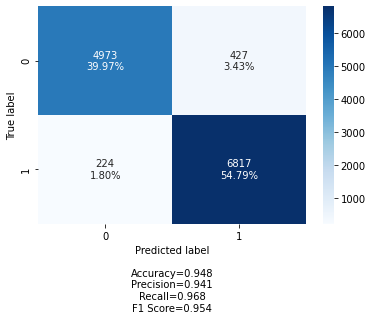

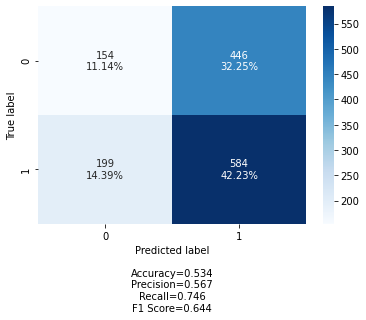

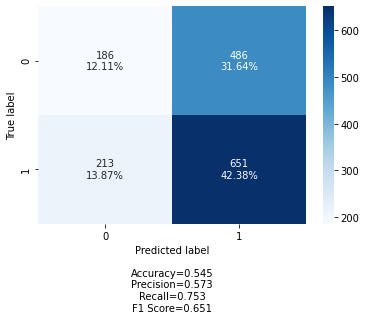

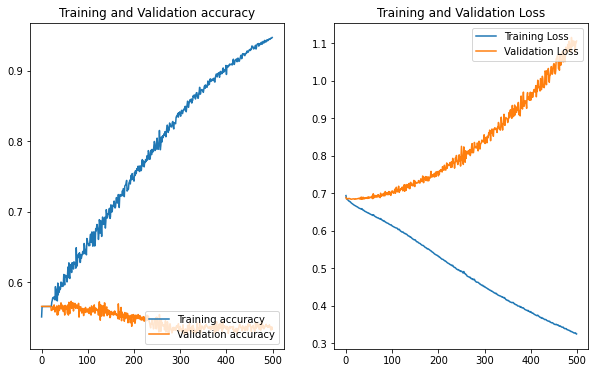

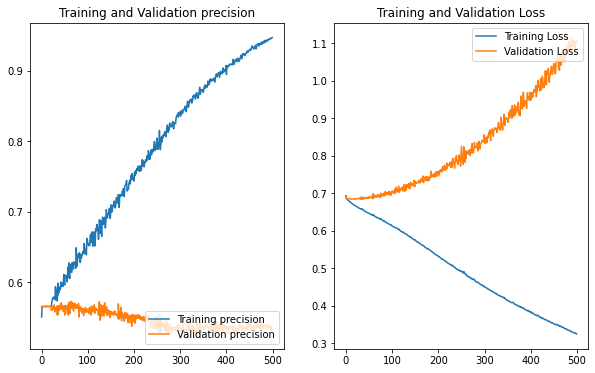

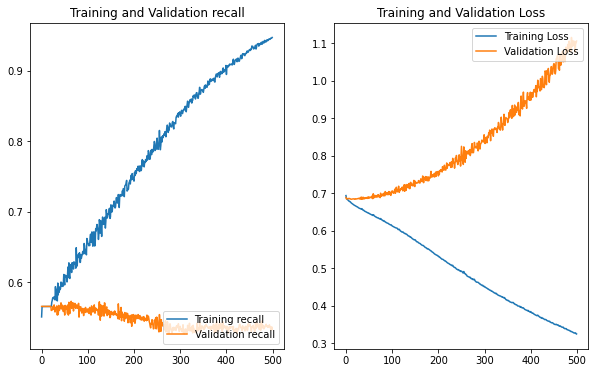

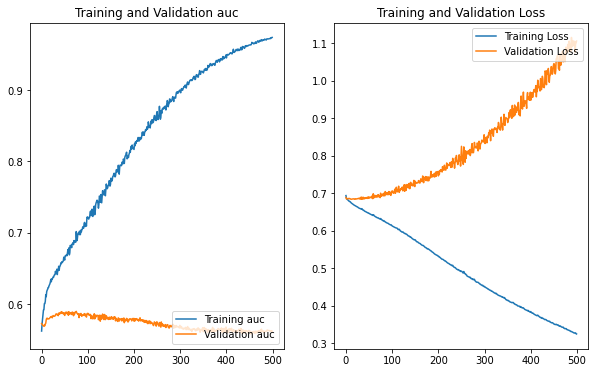


-----------------------------------------------------------------------------------------
INFO:tensorflow:Assets written to: /content/drive/MyDrive/major project/1D-CNN Models/Vanilla Models/bin_12_baseline/assets


0

In [53]:
baseline_models = dummy_models(sub_signals = 12, metrics = METRICS)
history = [0]*32
epochs = 500
#range will be 32 in actual code
for j in range(1):
  print(f'Individual Net : {j+1}')   
  x_train, x_val, y_train, y_val = train_test_split( X_train_12[j],y_train_12, test_size = 0.1, random_state = 42, shuffle = True, stratify = y_train_12)

  #Input Dependent dummy model
  history[j] = baseline_models[j].fit(x_train, y_train, batch_size = 2048, epochs = epochs, \
                                      validation_data = (x_val, y_val), shuffle = True, verbose = 0)
  
  show_metrics(x_train, x_val, y_train, y_val, baseline_models[j])
  show_test_metrics(x_test_12[j], y_test_12, baseline_models[j])
  
  plot_evaluation_curves(history[j], epochs, ('accuracy', 'val_accuracy'))
  plot_evaluation_curves(history[j], epochs, ('precision', 'val_precision'))
  plot_evaluation_curves(history[j], epochs, ('recall', 'val_recall'))
  plot_evaluation_curves(history[j], epochs, ('auc', 'val_auc'))
  print("\n-----------------------------------------------------------------------------------------")
  baseline_models[j].save("/content/drive/MyDrive/major project/1D-CNN Models/Vanilla Models/bin_12_baseline")
  gc.collect()
gc.collect()


In [54]:
# Fresh Start to training with freeing up of RAM
try:
  del models
  del history
except:
  print("Variables already freed")
gc.collect()

Variables already freed


50

Input Independent LP 1DCNN model

All models defined.
Individual Net : 1
TRAINING MEASURES: 
Counter({1: 12441}) Predicted Distribution of Training Dataset
Counter({1: 7041, 0: 5400}) Actual Distribution of Training Dataset
389/389 [==============================] - 2s 5ms/step - loss: 0.6846 - tp: 7041.0000 - fp: 5400.0000 - tn: 7041.0000 - fn: 5400.0000 - accuracy: 0.5660 - precision: 0.5660 - recall: 0.5660 - auc: 0.5660
[0.6845923662185669, 7041.0, 5400.0, 7041.0, 5400.0, 0.5659512877464294, 0.5659512877464294, 0.5659512877464294, 0.5659512877464294] Training Measures of Model.
Classification Report of Model on Training Data


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000      5400
           1     0.5660    1.0000    0.7228      7041

    accuracy                         0.5660     12441
   macro avg     0.2830    0.5000    0.3614     12441
weighted avg     0.3203    0.5660    0.4091     12441


------------------------------------------------------------------------------------------

VALIDATION MEASURES: 
Counter({1: 1383}) Predicted Distribution of Validation Dataset
Counter({1: 783, 0: 600}) Actual Distribution of Validation Dataset
44/44 [==============================] - 0s 5ms/step - loss: 0.6845 - tp: 783.0000 - fp: 600.0000 - tn: 783.0000 - fn: 600.0000 - accuracy: 0.5662 - precision: 0.5662 - recall: 0.5662 - auc: 0.5662
[0.684544563293457, 783.0, 600.0, 783.0, 600.0, 0.5661605000495911, 0.5661605000495911, 0.5661605000495911, 0.5661605000495911] Validation Measures of Model.
Classification Report of Model on Validation Data
              precis

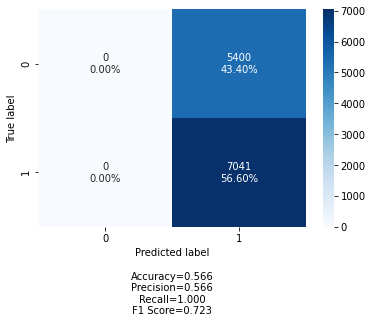

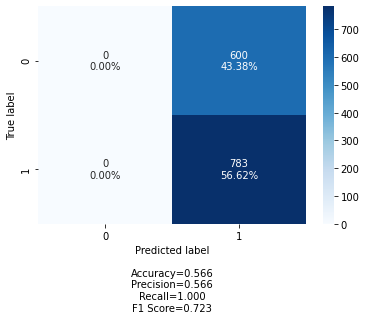

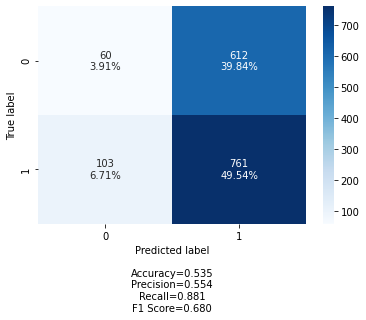

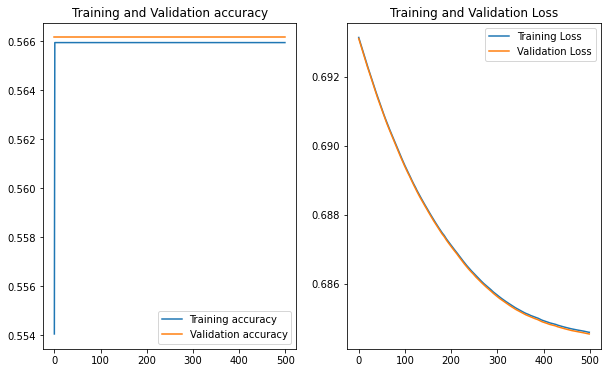

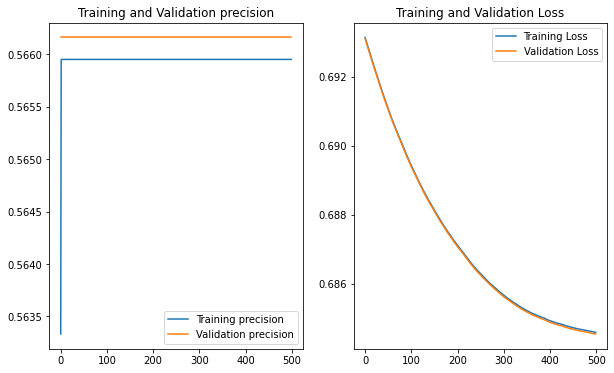

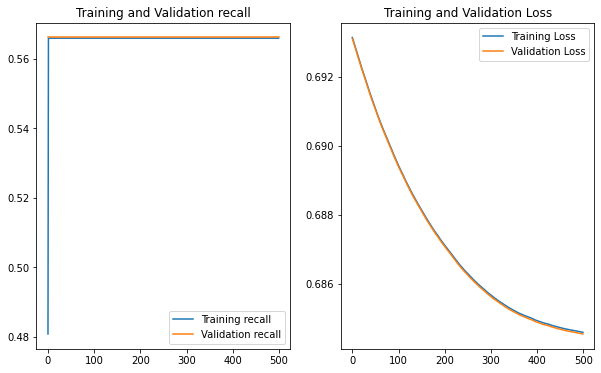

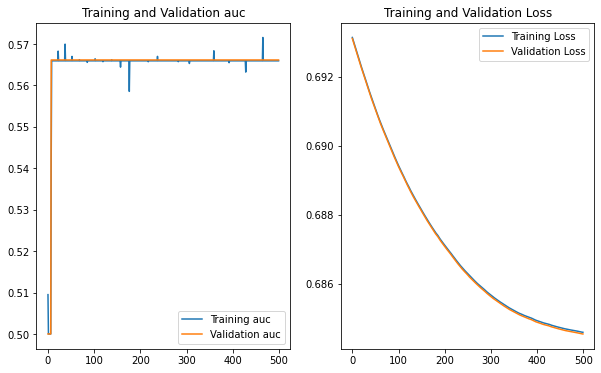


-----------------------------------------------------------------------------------------
INFO:tensorflow:Assets written to: /content/drive/MyDrive/major project/1D-CNN Models/Vanilla Models/bin_12_null_1DCNN/assets


0

In [55]:
models = create_models(dense_par = 20, sub_signals = 12, metrics = METRICS)
history = [0]*32
epochs = 500
#range will be 32 in actual code
for j in range(1):
  print(f'Individual Net : {j+1}')   
  #Null Data generation
  x_train, x_val, y_train, y_val = train_test_split( null_data,y_train_12, test_size = 0.1, random_state = 42, shuffle = True, stratify = y_train_12)
  history[j] = models[j].fit(x_train, y_train, batch_size = 2048, epochs = epochs, \
                             validation_data = (x_val, y_val), shuffle = True, verbose = 0)
  
  show_metrics(x_train, x_val, y_train, y_val, models[j])
  show_test_metrics(x_test_12[j], y_test_12, models[j])
  
  plot_evaluation_curves(history[j], epochs, ('accuracy', 'val_accuracy'))
  plot_evaluation_curves(history[j], epochs, ('precision', 'val_precision'))
  plot_evaluation_curves(history[j], epochs, ('recall', 'val_recall'))
  plot_evaluation_curves(history[j], epochs, ('auc', 'val_auc'))
  print("\n-----------------------------------------------------------------------------------------")
  models[j].save("/content/drive/MyDrive/major project/1D-CNN Models/Vanilla Models/bin_12_null_1DCNN")
  gc.collect()
gc.collect()


In [56]:
# Fresh Start to training with freeing up of RAM
try:
  del models
  del history
except:
  print("Variables already freed")
gc.collect()

58501

LP 1DCNN Input Dependent

All models defined.
Individual Net : 1
TRAINING MEASURES: 
Counter({1: 11645, 0: 796}) Predicted Distribution of Training Dataset
Counter({1: 7041, 0: 5400}) Actual Distribution of Training Dataset
389/389 [==============================] - 2s 5ms/step - loss: 0.6292 - tp: 7427.0000 - fp: 5014.0000 - tn: 7427.0000 - fn: 5014.0000 - accuracy: 0.5970 - precision: 0.5970 - recall: 0.5970 - auc: 0.6964
[0.6291685700416565, 7427.0, 5014.0, 7427.0, 5014.0, 0.596977710723877, 0.596977710723877, 0.596977710723877, 0.6964393854141235] Training Measures of Model.
Classification Report of Model on Training Data
              precision    recall  f1-score   support

           0     0.7425    0.1094    0.1908      5400
           1     0.5870    0.9709    0.7317      7041

    accuracy                         0.5970     12441
   macro avg     0.6647    0.5402    0.4612     12441
weighted avg     0.6545    0.5970    0.4969     12441


----------------------------------------------------------------

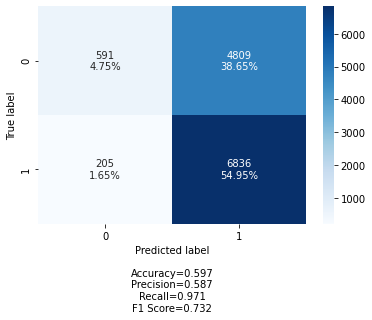

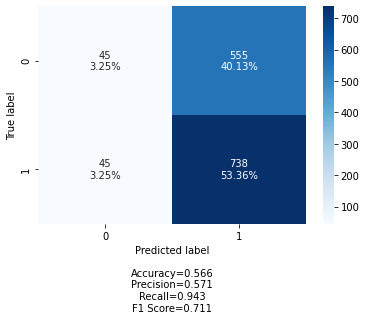

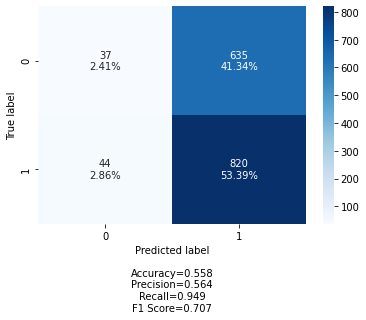

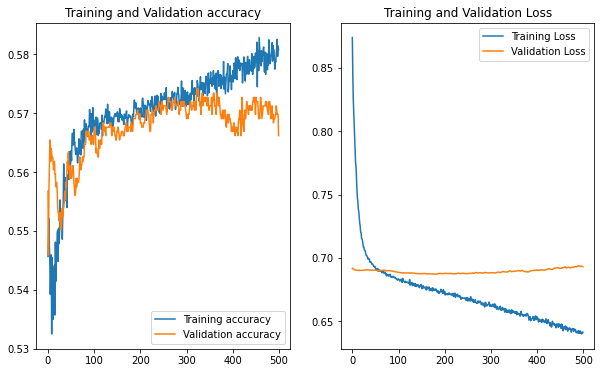

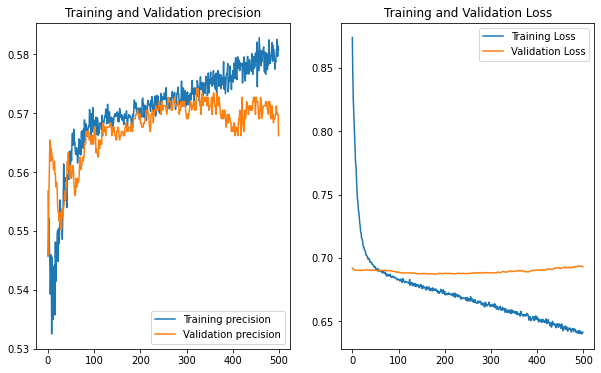

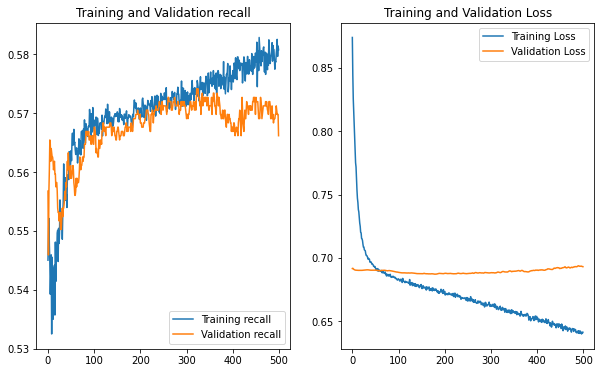

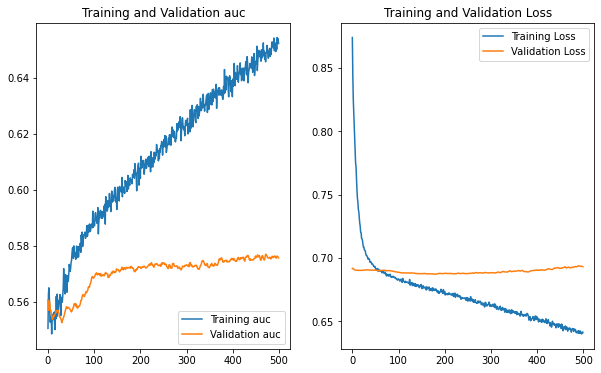


-----------------------------------------------------------------------------------------
INFO:tensorflow:Assets written to: /content/drive/MyDrive/major project/1D-CNN Models/Vanilla Models/bin_12_1DCNN/assets


0

In [57]:
models = create_models(dense_par = 20, sub_signals = 12, metrics = METRICS)
history = [0]*32
epochs = 500
#range will be 32 in actual code
for j in range(1):
  print(f'Individual Net : {j+1}')   
  x_train, x_val, y_train, y_val = train_test_split( X_train_12[j],y_train_12, test_size = 0.1, random_state = 42, shuffle = True, stratify = y_train_12)
  #Actual Model Training with real data
  history[j] = models[j].fit(x_train, y_train, batch_size = 2048, epochs = epochs, validation_data = (x_val, y_val),\
                             shuffle = True, verbose = 0)
  show_metrics(x_train, x_val, y_train, y_val, models[j])
  show_test_metrics(x_test_12[j], y_test_12, models[j])
  plot_evaluation_curves(history[j], epochs, ('accuracy', 'val_accuracy'))
  plot_evaluation_curves(history[j], epochs, ('precision', 'val_precision'))
  plot_evaluation_curves(history[j], epochs, ('recall', 'val_recall'))
  plot_evaluation_curves(history[j], epochs, ('auc', 'val_auc'))
  print("\n-----------------------------------------------------------------------------------------")
  models[j].save("/content/drive/MyDrive/major project/1D-CNN Models/Vanilla Models/bin_12_1DCNN")
  gc.collect()
gc.collect()


### With Class Weights set

In [58]:
# Fresh Start to training with freeing up of RAM
try:
  del models
  del history
except:
  print("Variables already freed")
gc.collect()

58501

Input Dependent Baseline Model

All models defined.
Individual Net : 1
TRAINING MEASURES: 
Counter({1: 7042, 0: 5399}) Predicted Distribution of Training Dataset
Counter({1: 7041, 0: 5400}) Actual Distribution of Training Dataset
389/389 [==============================] - 2s 5ms/step - loss: 0.0305 - tp: 12434.0000 - fp: 7.0000 - tn: 12434.0000 - fn: 7.0000 - accuracy: 0.9994 - precision: 0.9994 - recall: 0.9994 - auc: 1.0000
[0.03048236481845379, 12434.0, 7.0, 12434.0, 7.0, 0.9994373321533203, 0.9994373321533203, 0.9994373321533203, 0.9999984502792358] Training Measures of Model.
Classification Report of Model on Training Data
              precision    recall  f1-score   support

           0     0.9994    0.9993    0.9994      5400
           1     0.9994    0.9996    0.9995      7041

    accuracy                         0.9994     12441
   macro avg     0.9994    0.9994    0.9994     12441
weighted avg     0.9994    0.9994    0.9994     12441


--------------------------------------------------------------------

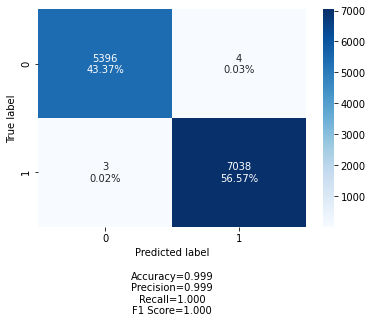

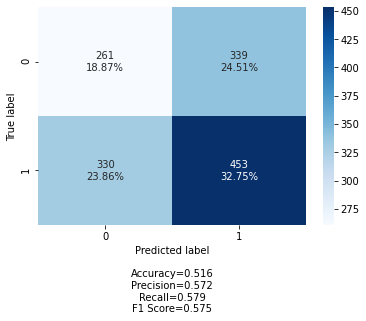

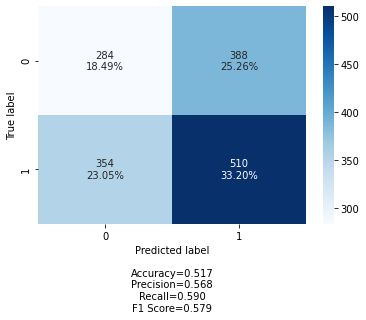

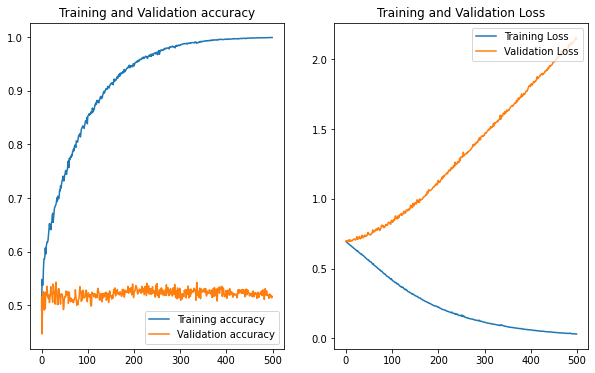

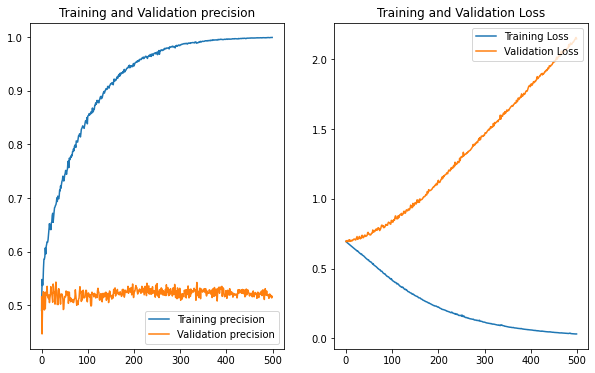

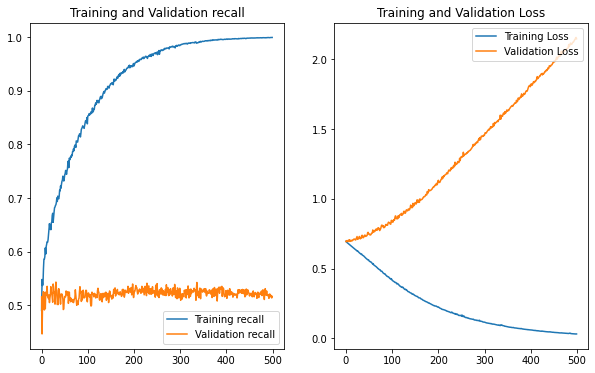

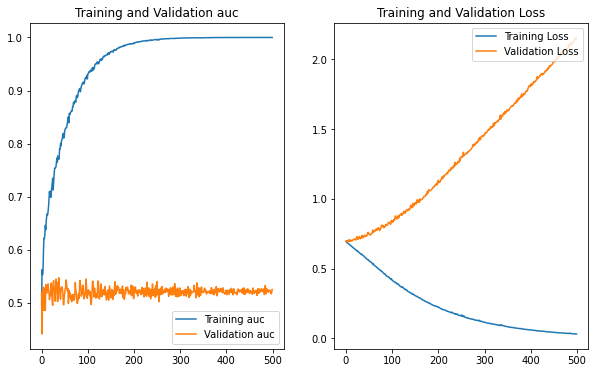


-----------------------------------------------------------------------------------------
INFO:tensorflow:Assets written to: /content/drive/MyDrive/major project/1D-CNN Models/Model with Class Weights/bin_12_baseline/assets


0

In [59]:
baseline_models = dummy_models(sub_signals = 12, metrics = METRICS)
history = [0]*32
epochs = 500
#range will be 32 in actual code
for j in range(1):
  print(f'Individual Net : {j+1}')   
  x_train, x_val, y_train, y_val = train_test_split( X_train_12[j],y_train_12, test_size = 0.1, random_state = 42, shuffle = True, stratify = y_train_12)

  #Input Dependent dummy model
  history[j] = baseline_models[j].fit(x_train, y_train, batch_size = 2048, epochs = epochs, \
                                      validation_data = (x_val, y_val),  class_weight = d_bin_class_weights, shuffle = True, verbose = 0)
  
  show_metrics(x_train, x_val, y_train, y_val, baseline_models[j])
  show_test_metrics(x_test_12[j], y_test_12, baseline_models[j])

  plot_evaluation_curves(history[j], epochs, ('accuracy', 'val_accuracy'))
  plot_evaluation_curves(history[j], epochs, ('precision', 'val_precision'))
  plot_evaluation_curves(history[j], epochs, ('recall', 'val_recall'))
  plot_evaluation_curves(history[j], epochs, ('auc', 'val_auc'))
  print("\n-----------------------------------------------------------------------------------------")
  baseline_models[j].save("/content/drive/MyDrive/major project/1D-CNN Models/Model with Class Weights/bin_12_baseline")
  gc.collect()
gc.collect()


In [60]:
# Fresh Start to training with freeing up of RAM
try:
  del models
  del history
except:
  print("Variables already freed")
gc.collect()

Variables already freed


50

Input Independent LP 1DCNN model

All models defined.
Individual Net : 1
TRAINING MEASURES: 
Counter({1: 12441}) Predicted Distribution of Training Dataset
Counter({1: 7041, 0: 5400}) Actual Distribution of Training Dataset
389/389 [==============================] - 2s 5ms/step - loss: 0.6931 - tp: 7041.0000 - fp: 5400.0000 - tn: 7041.0000 - fn: 5400.0000 - accuracy: 0.5660 - precision: 0.5660 - recall: 0.5660 - auc: 0.5000
[0.6930859684944153, 7041.0, 5400.0, 7041.0, 5400.0, 0.5659512877464294, 0.5659512877464294, 0.5659512877464294, 0.5] Training Measures of Model.
Classification Report of Model on Training Data


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000      5400
           1     0.5660    1.0000    0.7228      7041

    accuracy                         0.5660     12441
   macro avg     0.2830    0.5000    0.3614     12441
weighted avg     0.3203    0.5660    0.4091     12441


------------------------------------------------------------------------------------------

VALIDATION MEASURES: 
Counter({1: 1383}) Predicted Distribution of Validation Dataset
Counter({1: 783, 0: 600}) Actual Distribution of Validation Dataset
44/44 [==============================] - 0s 5ms/step - loss: 0.6931 - tp: 783.0000 - fp: 600.0000 - tn: 783.0000 - fn: 600.0000 - accuracy: 0.5662 - precision: 0.5662 - recall: 0.5662 - auc: 0.5000
[0.6930869221687317, 783.0, 600.0, 783.0, 600.0, 0.5661605000495911, 0.5661605000495911, 0.5661605000495911, 0.5] Validation Measures of Model.
Classification Report of Model on Validation Data
              precision    recall 

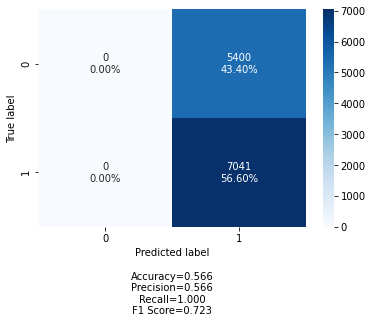

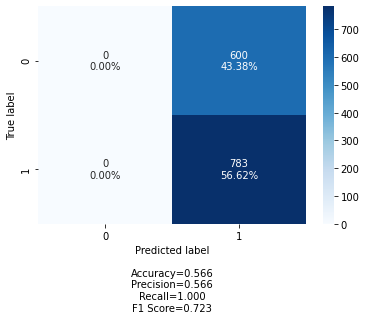

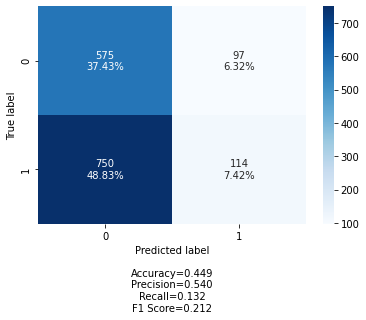

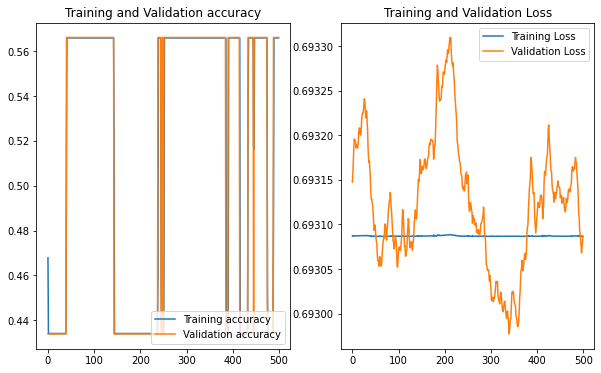

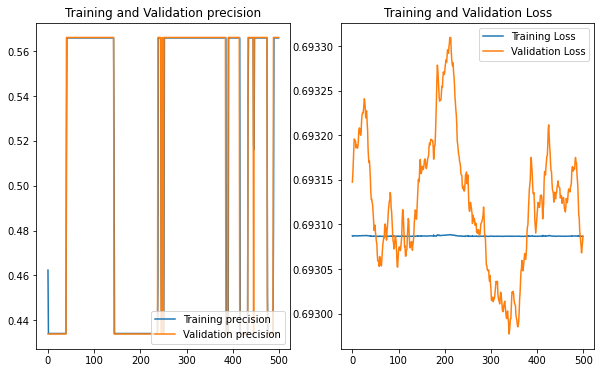

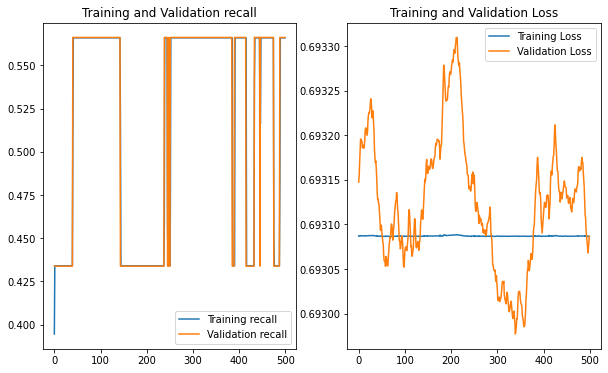

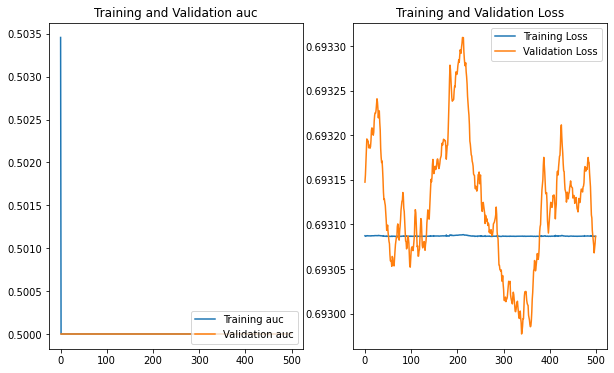


-----------------------------------------------------------------------------------------
INFO:tensorflow:Assets written to: /content/drive/MyDrive/major project/1D-CNN Models/Model with Class Weights/bin_12_null_1DCNN/assets


0

In [61]:
models = create_models(dense_par = 20, sub_signals = 12, metrics = METRICS)
history = [0]*32
epochs = 500
#range will be 32 in actual code
for j in range(1):
  print(f'Individual Net : {j+1}')   
  #Null Data generation
  x_train, x_val, y_train, y_val = train_test_split( null_data,y_train_12, test_size = 0.1, random_state = 42, shuffle = True, stratify = y_train_12)
  history[j] = models[j].fit(x_train, y_train, batch_size = 2048, epochs = epochs, \
                             validation_data = (x_val, y_val),  class_weight = d_bin_class_weights, shuffle = True, verbose = 0)
  
  show_metrics(x_train, x_val, y_train, y_val, models[j])
  show_test_metrics(x_test_12[j], y_test_12, models[j])

  plot_evaluation_curves(history[j], epochs, ('accuracy', 'val_accuracy'))
  plot_evaluation_curves(history[j], epochs, ('precision', 'val_precision'))
  plot_evaluation_curves(history[j], epochs, ('recall', 'val_recall'))
  plot_evaluation_curves(history[j], epochs, ('auc', 'val_auc'))
  print("\n-----------------------------------------------------------------------------------------")
  models[j].save("/content/drive/MyDrive/major project/1D-CNN Models/Model with Class Weights/bin_12_null_1DCNN")
  gc.collect()
gc.collect()


In [62]:
# Fresh Start to training with freeing up of RAM
try:
  del models
  del history
except:
  print("Variables already freed")
gc.collect()

58501

LP 1DCNN Input Dependent

All models defined.
Individual Net : 1
TRAINING MEASURES: 
Counter({1: 7021, 0: 5420}) Predicted Distribution of Training Dataset
Counter({1: 7041, 0: 5400}) Actual Distribution of Training Dataset
389/389 [==============================] - 2s 5ms/step - loss: 0.6323 - tp: 8383.0000 - fp: 4058.0000 - tn: 8383.0000 - fn: 4058.0000 - accuracy: 0.6738 - precision: 0.6738 - recall: 0.6738 - auc: 0.7468
[0.6322925686836243, 8383.0, 4058.0, 8383.0, 4058.0, 0.673820436000824, 0.673820436000824, 0.673820436000824, 0.7468142509460449] Training Measures of Model.
Classification Report of Model on Training Data
              precision    recall  f1-score   support

           0     0.6238    0.6261    0.6250      5400
           1     0.7124    0.7104    0.7114      7041

    accuracy                         0.6738     12441
   macro avg     0.6681    0.6683    0.6682     12441
weighted avg     0.6740    0.6738    0.6739     12441


----------------------------------------------------------------

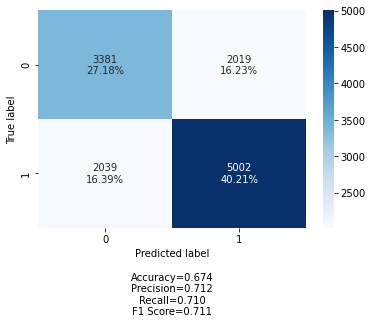

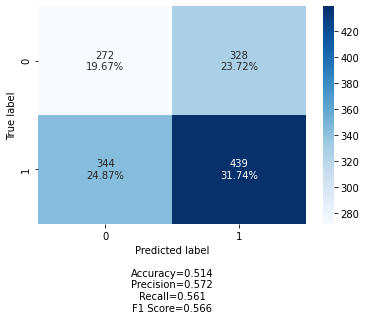

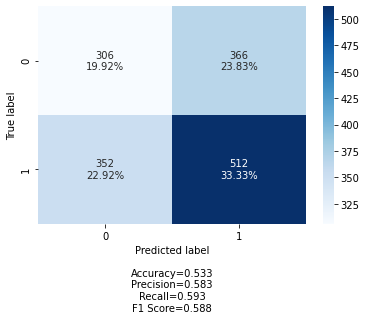

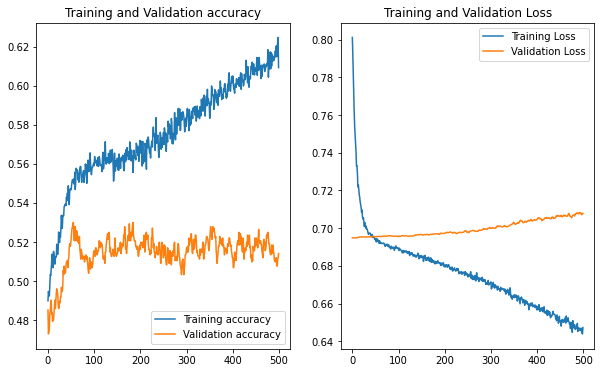

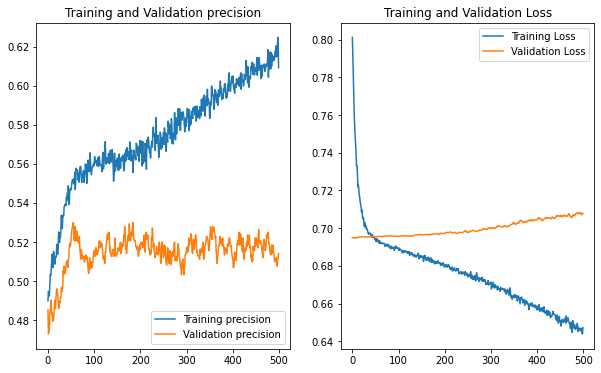

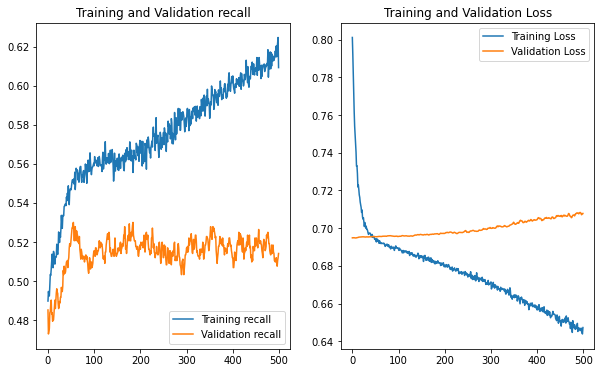

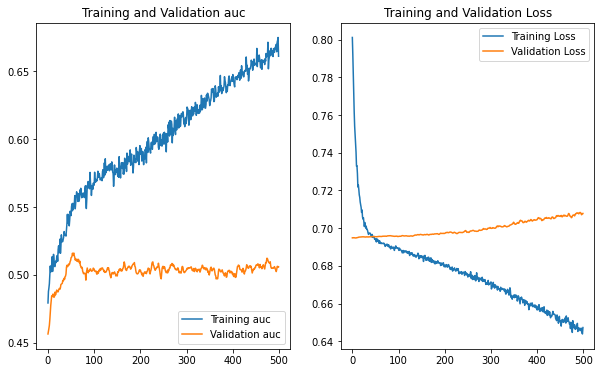


-----------------------------------------------------------------------------------------
INFO:tensorflow:Assets written to: /content/drive/MyDrive/major project/1D-CNN Models/Model with Class Weights/bin_12_1DCNN/assets


0

In [63]:
models = create_models(dense_par = 20, sub_signals = 12, metrics = METRICS)
history = [0]*32
epochs = 500
#range will be 32 in actual code
for j in range(1):
  print(f'Individual Net : {j+1}')   
  x_train, x_val, y_train, y_val = train_test_split( X_train_12[j],y_train_12, test_size = 0.1, random_state = 42, shuffle = True, stratify = y_train_12)
  #Actual Model Training with real data
  history[j] = models[j].fit(x_train, y_train, batch_size = 2048, epochs = epochs, validation_data = (x_val, y_val),\
                             class_weight = d_bin_class_weights, shuffle = True, verbose = 0)
  show_metrics(x_train, x_val, y_train, y_val, models[j])
  show_test_metrics(x_test_12[j], y_test_12, models[j])
  plot_evaluation_curves(history[j], epochs, ('accuracy', 'val_accuracy'))
  plot_evaluation_curves(history[j], epochs, ('precision', 'val_precision'))
  plot_evaluation_curves(history[j], epochs, ('recall', 'val_recall'))
  plot_evaluation_curves(history[j], epochs, ('auc', 'val_auc'))
  print("\n-----------------------------------------------------------------------------------------")
  models[j].save("/content/drive/MyDrive/major project/1D-CNN Models/Model with Class Weights/bin_12_1DCNN")
  gc.collect()
gc.collect()


### With Resampling Done using SMOTE

In [64]:
# Fresh Start to training with freeing up of RAM
try:
  del models
  del history
except:
  print("Variables already freed")
gc.collect()

58504

Input Dependent Baseline Model

All models defined.
Individual Net : 1


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Resampled Using SMOTE.
TRAINING MEASURES: 
Counter({0: 7045, 1: 7037}) Predicted Distribution of Training Dataset
Counter({1: 7041, 0: 7041}) Actual Distribution of Training Dataset
441/441 [==============================] - 2s 5ms/step - loss: 0.0324 - tp: 14076.0000 - fp: 6.0000 - tn: 14076.0000 - fn: 6.0000 - accuracy: 0.9996 - precision: 0.9996 - recall: 0.9996 - auc: 1.0000
[0.03235547989606857, 14076.0, 6.0, 14076.0, 6.0, 0.9995739459991455, 0.9995739459991455, 0.9995739459991455, 0.99998539686203] Training Measures of Model.
Classification Report of Model on Training Data
              precision    recall  f1-score   support

           0     0.9993    0.9999    0.9996      7041
           1     0.9999    0.9993    0.9996      7041

    accuracy                         0.9996     14082
   macro avg     0.9996    0.9996    0.9996     14082
weighted avg     0.9996    0.9996    0.9996     14082


--------------------------------------------------------------------------------------

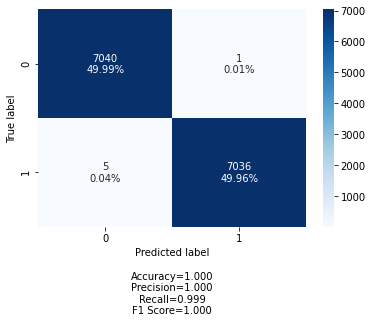

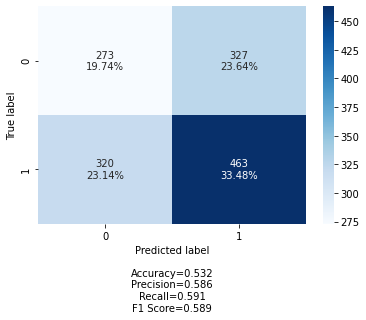

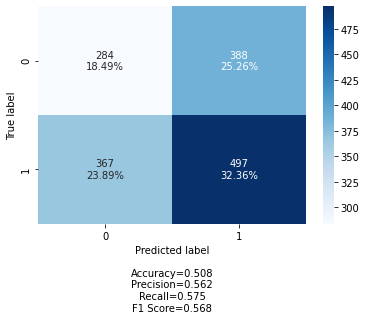

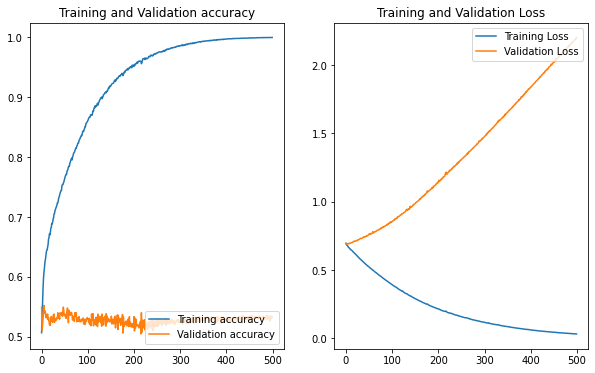

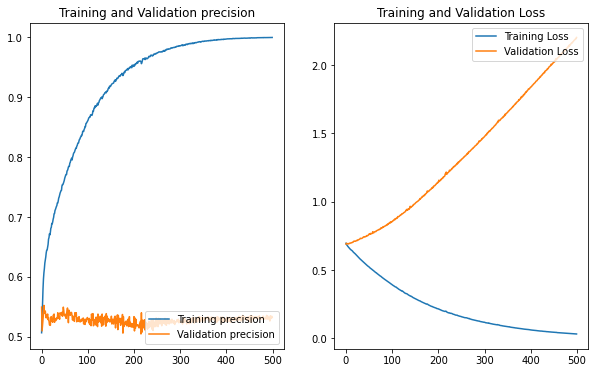

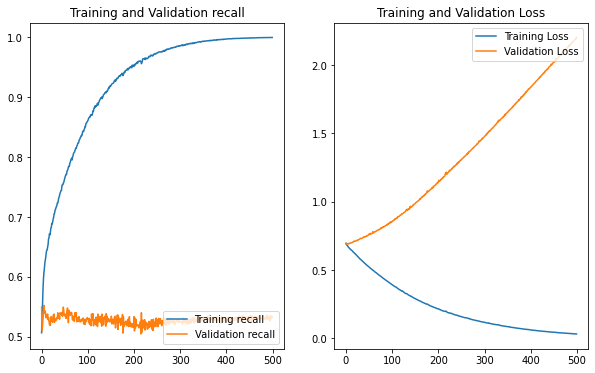

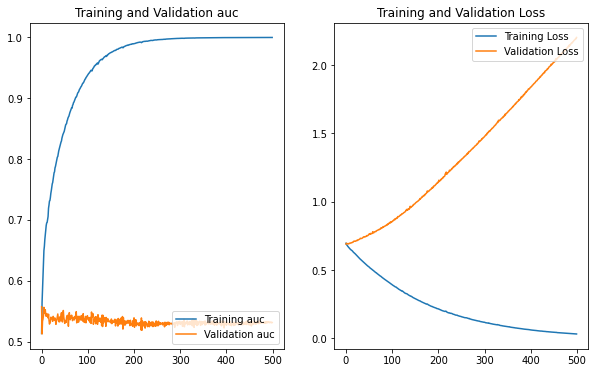


-----------------------------------------------------------------------------------------
INFO:tensorflow:Assets written to: /content/drive/MyDrive/major project/1D-CNN Models/Model with SMOTE/bin_12_baseline/assets


0

In [65]:
baseline_models = dummy_models(sub_signals = 12, metrics = METRICS)
history = [0]*32
epochs = 500
#range will be 32 in actual code
for j in range(1):
  print(f'Individual Net : {j+1}')   
  x_train, x_val, y_train, y_val = train_test_split( X_train_12[j],y_train_12, test_size = 0.1, random_state = 42, shuffle = True, stratify = y_train_12)
  x_train = x_train.reshape((x_train.shape[0], x_train.shape[1]))
  y_train = np.argmax(y_train, axis = 1)
  x_train, y_train = SMOTE(random_state=RANDOM_SEED).fit_resample(x_train,y_train)
  print("Resampled Using SMOTE.")
  y_train = np.array(list(map(encode, y_train)))
  x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
  #Input Dependent dummy model
  history[j] = baseline_models[j].fit(x_train, y_train, batch_size = 2048, epochs = epochs, \
                                      validation_data = (x_val, y_val), shuffle = True, verbose = 0)
  
  show_metrics(x_train, x_val, y_train, y_val, baseline_models[j])
  show_test_metrics(x_test_12[j], y_test_12, baseline_models[j])
  plot_evaluation_curves(history[j], epochs, ('accuracy', 'val_accuracy'))
  plot_evaluation_curves(history[j], epochs, ('precision', 'val_precision'))
  plot_evaluation_curves(history[j], epochs, ('recall', 'val_recall'))
  plot_evaluation_curves(history[j], epochs, ('auc', 'val_auc'))
  print("\n-----------------------------------------------------------------------------------------")
  baseline_models[j].save("/content/drive/MyDrive/major project/1D-CNN Models/Model with SMOTE/bin_12_baseline")
  gc.collect()
gc.collect()


In [66]:
# Fresh Start to training with freeing up of RAM
try:
  del models
  del history
except:
  print("Variables already freed")
gc.collect()

Variables already freed


50

Input Independent LP 1DCNN model

All models defined.
Individual Net : 1


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Resampled Using SMOTE.
TRAINING MEASURES: 
Counter({1: 14082}) Predicted Distribution of Training Dataset
Counter({1: 7041, 0: 7041}) Actual Distribution of Training Dataset
441/441 [==============================] - 2s 5ms/step - loss: 0.6931 - tp: 7041.0000 - fp: 7041.0000 - tn: 7041.0000 - fn: 7041.0000 - accuracy: 0.5000 - precision: 0.5000 - recall: 0.5000 - auc: 0.5000
[0.6931480765342712, 7041.0, 7041.0, 7041.0, 7041.0, 0.5, 0.5, 0.5, 0.5] Training Measures of Model.
Classification Report of Model on Training Data


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000      7041
           1     0.5000    1.0000    0.6667      7041

    accuracy                         0.5000     14082
   macro avg     0.2500    0.5000    0.3333     14082
weighted avg     0.2500    0.5000    0.3333     14082


------------------------------------------------------------------------------------------

VALIDATION MEASURES: 
Counter({1: 1383}) Predicted Distribution of Validation Dataset
Counter({1: 783, 0: 600}) Actual Distribution of Validation Dataset
44/44 [==============================] - 0s 5ms/step - loss: 0.6931 - tp: 783.0000 - fp: 600.0000 - tn: 783.0000 - fn: 600.0000 - accuracy: 0.5662 - precision: 0.5662 - recall: 0.5662 - auc: 0.5000
[0.6931401491165161, 783.0, 600.0, 783.0, 600.0, 0.5661605000495911, 0.5661605000495911, 0.5661605000495911, 0.5] Validation Measures of Model.
Classification Report of Model on Validation Data
              precision    recall 

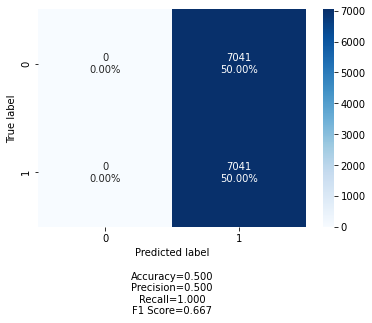

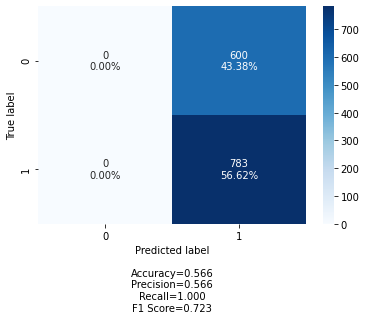

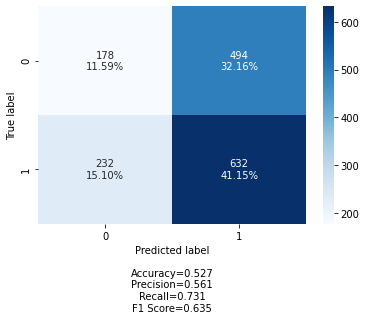

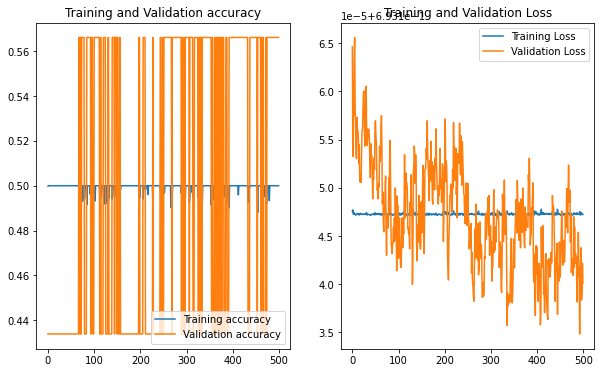

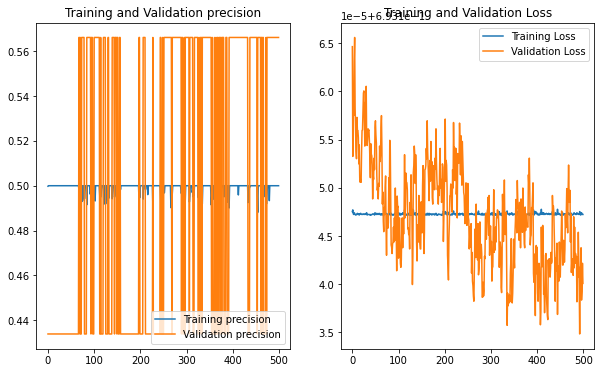

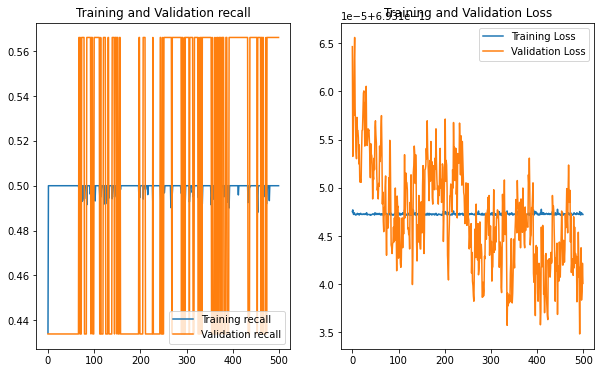

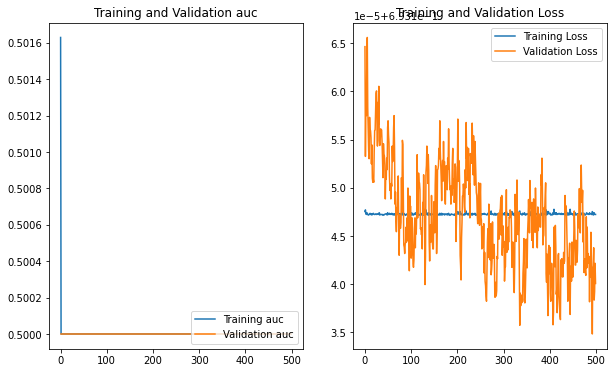


-----------------------------------------------------------------------------------------
INFO:tensorflow:Assets written to: /content/drive/MyDrive/major project/1D-CNN Models/Model with SMOTE/bin_12_null_1DCNN/assets


0

In [67]:
models = create_models(dense_par = 20, sub_signals = 12, metrics = METRICS)
history = [0]*32
epochs = 500
#range will be 32 in actual code
for j in range(1):
  print(f'Individual Net : {j+1}')   
  #Null Data generation
  x_train, x_val, y_train, y_val = train_test_split( null_data,y_train_12, test_size = 0.1, random_state = 42, shuffle = True, stratify = y_train_12)
  x_train = x_train.reshape((x_train.shape[0], x_train.shape[1]))
  y_train = np.argmax(y_train, axis = 1)
  x_train, y_train = SMOTE(random_state=RANDOM_SEED).fit_resample(x_train,y_train)
  print("Resampled Using SMOTE.")
  y_train = np.array(list(map(encode, y_train)))
  x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))

  history[j] = models[j].fit(x_train, y_train, batch_size = 2048, epochs = epochs, \
                             validation_data = (x_val, y_val), shuffle = True, verbose = 0)
  
  show_metrics(x_train, x_val, y_train, y_val, models[j])
  show_test_metrics(x_test_12[j], y_test_12, models[j])
  plot_evaluation_curves(history[j], epochs, ('accuracy', 'val_accuracy'))
  plot_evaluation_curves(history[j], epochs, ('precision', 'val_precision'))
  plot_evaluation_curves(history[j], epochs, ('recall', 'val_recall'))
  plot_evaluation_curves(history[j], epochs, ('auc', 'val_auc'))
  print("\n-----------------------------------------------------------------------------------------")
  models[j].save("/content/drive/MyDrive/major project/1D-CNN Models/Model with SMOTE/bin_12_null_1DCNN")
  gc.collect()
gc.collect()


In [68]:
# Fresh Start to training with freeing up of RAM
try:
  del models
  del history
except:
  print("Variables already freed")
gc.collect()

58501

LP 1DCNN Input Dependent

All models defined.
Individual Net : 1


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Resampled Using SMOTE.
TRAINING MEASURES: 
Counter({0: 7577, 1: 6505}) Predicted Distribution of Training Dataset
Counter({1: 7041, 0: 7041}) Actual Distribution of Training Dataset
441/441 [==============================] - 2s 5ms/step - loss: 0.6057 - tp: 9788.0000 - fp: 4294.0000 - tn: 9788.0000 - fn: 4294.0000 - accuracy: 0.6951 - precision: 0.6951 - recall: 0.6951 - auc: 0.7633
[0.6057358384132385, 9788.0, 4294.0, 9788.0, 4294.0, 0.6950716972351074, 0.6950716972351074, 0.6950716972351074, 0.7633385062217712] Training Measures of Model.
Classification Report of Model on Training Data
              precision    recall  f1-score   support

           0     0.6813    0.7331    0.7063      7041
           1     0.7111    0.6570    0.6830      7041

    accuracy                         0.6951     14082
   macro avg     0.6962    0.6951    0.6946     14082
weighted avg     0.6962    0.6951    0.6946     14082


-----------------------------------------------------------------------------

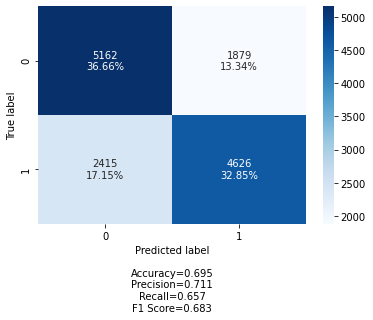

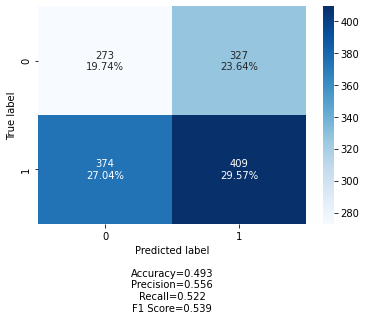

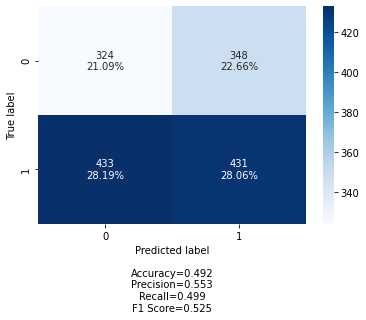

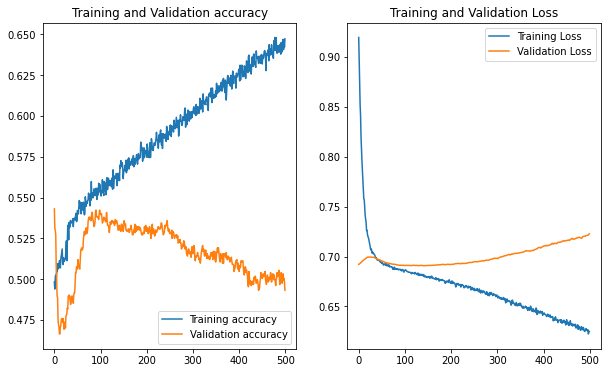

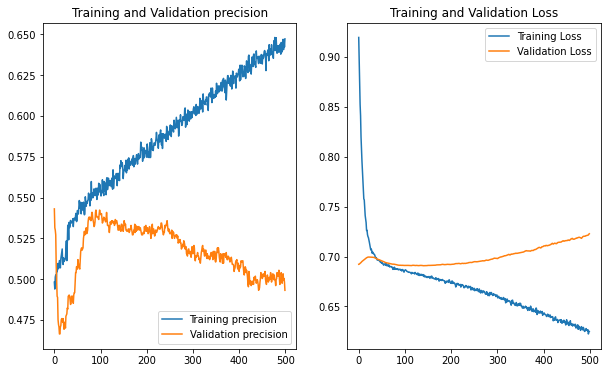

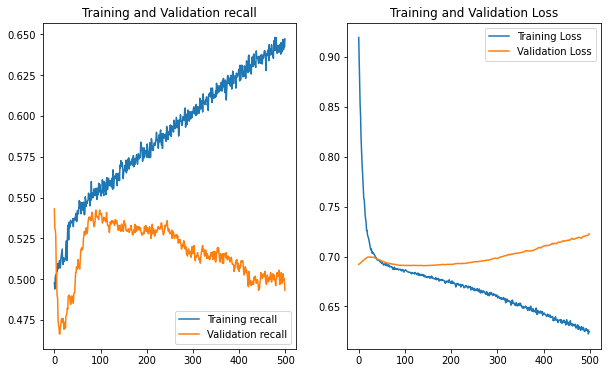

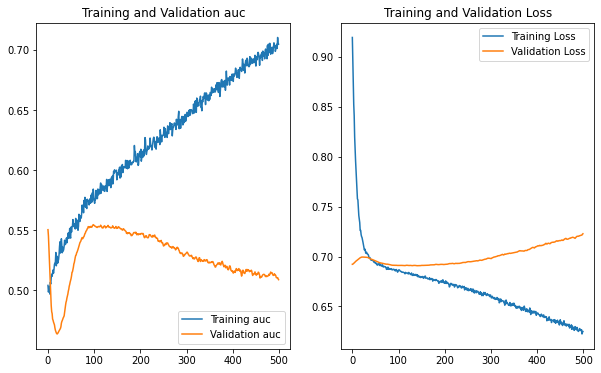


-----------------------------------------------------------------------------------------
INFO:tensorflow:Assets written to: /content/drive/MyDrive/major project/1D-CNN Models/Model with SMOTE/bin_12_1DCNN/assets


0

In [69]:
models = create_models(dense_par = 20, sub_signals = 12, metrics = METRICS)
history = [0]*32
epochs = 500
#range will be 32 in actual code
for j in range(1):
  print(f'Individual Net : {j+1}')   
  x_train, x_val, y_train, y_val = train_test_split( X_train_12[j],y_train_12, test_size = 0.1, random_state = 42, shuffle = True, stratify = y_train_12)
  x_train = x_train.reshape((x_train.shape[0], x_train.shape[1]))
  y_train = np.argmax(y_train, axis = 1)
  x_train, y_train = SMOTE(random_state=RANDOM_SEED).fit_resample(x_train,y_train)
  print("Resampled Using SMOTE.")
  y_train = np.array(list(map(encode, y_train)))
  x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
  #Actual Model Training with real data
  history[j] = models[j].fit(x_train, y_train, batch_size = 2048, \
                             epochs = epochs, validation_data = (x_val, y_val), shuffle = True, verbose = 0)
  show_metrics(x_train, x_val, y_train, y_val, models[j])
  show_test_metrics(x_test_12[j], y_test_12, models[j])
  plot_evaluation_curves(history[j], epochs, ('accuracy', 'val_accuracy'))
  plot_evaluation_curves(history[j], epochs, ('precision', 'val_precision'))
  plot_evaluation_curves(history[j], epochs, ('recall', 'val_recall'))
  plot_evaluation_curves(history[j], epochs, ('auc', 'val_auc'))
  print("\n-----------------------------------------------------------------------------------------")
  models[j].save("/content/drive/MyDrive/major project/1D-CNN Models/Model with SMOTE/bin_12_1DCNN")
  gc.collect()
gc.collect()


# Ensemble Algorithm:

In [70]:
#loop over test instances i.e. 128
  #loop over 32 channels i.e. 1 model for each channel
    #for each channel, pass the shape (sub_singals,samples,1) to M(i), here sub_signals will be the batch_size
    #get all predictions for a single channel's all samples, take their mode. This is the prediction for that channel
    #store all the channels' predicitions in an array
  #take mode for all channels' predictions from array, this is the predicted value for that instance